<a href="https://colab.research.google.com/github/gitboku/myKaggle/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 参考
http://yusuke-ujitoko.hatenablog.com/entry/2017/05/08/010314

https://www.kaggle.com/nassimyagoub/gan-anime-faces

# データ用意

https://www.kaggle.com/soumikrakshit/anime-faces

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"neelylee","key":"e2dd8aca6835607b914de39efd3f6a44"}'}

In [ ]:
!cp /content/drive/My\ Drive/kaggle/kaggle.json /root/.kaggle/
!kaggle datasets download -d soumikrakshit/anime-faces

100% 439M/441M [00:05<00:00, 97.2MB/s]
100% 441M/441M [00:05<00:00, 84.7MB/s]


マウントしたdriveにおいておかないと、毎回データをダウンロードする羽目になる。

In [ ]:
!cp /content/anime-faces.zip /content/drive/My\ Drive/kaggle/

In [ ]:
!unzip /content/drive/My\ Drive/kaggle/anime-faces.zip -d /content/anime-faces

In [7]:
!ls -la /content/anime-faces/data/ | head

total 259504
drwxr-xr-x 3 root root 536576 Aug  8 05:29 .
drwxr-xr-x 3 root root   4096 Aug  8 05:29 ..
-rw-r--r-- 1 root root  10453 Oct 23  2019 10000.png
-rw-r--r-- 1 root root  11378 Oct 23  2019 10001.png
-rw-r--r-- 1 root root  10835 Oct 23  2019 10002.png
-rw-r--r-- 1 root root  10928 Oct 23  2019 10003.png
-rw-r--r-- 1 root root  10612 Oct 23  2019 10004.png
-rw-r--r-- 1 root root  11025 Oct 23  2019 10005.png
-rw-r--r-- 1 root root  11419 Oct 23  2019 10006.png


# GANアルゴリズム実装

## 訓練データ用意

In [15]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd 

import keras
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

import cv2

In [ ]:
!ls -U1 /content/anime-faces/data/ | grep jpg | wc -l
!ls -U1 /content/anime-faces/data/ | grep jpeg | wc -l
!ls -U1 /content/anime-faces/data/ | grep png | wc -l

0
0
21551


In [9]:
# https://www.kaggle.com/nassimyagoub/gan-anime-faces
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                
def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    print(imagePaths[:5])
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            # OpenCVで読み込んだ画像はBGR（青、緑、赤）なので、それをRGBの順に直す
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [10]:
images = load_images('/content/anime-faces/data')

['/content/anime-faces/data/4486.png', '/content/anime-faces/data/3866.png', '/content/anime-faces/data/7282.png', '/content/anime-faces/data/7517.png', '/content/anime-faces/data/703.png']


In [11]:
tmp_images = np.array(images)
# (pixel, pixel , rgb) = (43102, 64, 64, 3) の画像が43102個
print(tmp_images.shape)

(43102, 64, 64, 3)


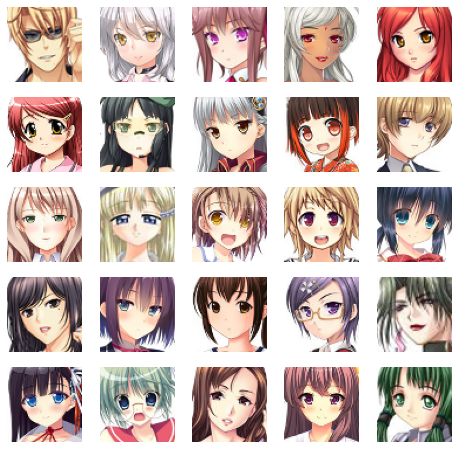

In [12]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

## 学習モデル作成
ただのGANではなくDCGAN(Deep Convolutional GAN)にする。  
基本的なネットワークは変わらず、各ノードの接続方法が少し変わるだけ。

参考  
https://www.kaggle.com/nassimyagoub/gan-anime-faces

In [24]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']
            )

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        epsilon = 0.00001
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(
            512,
            kernel_size=[4,4],
            strides=[2,2],
            padding="same",
            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)
            ))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(
            256,
            kernel_size=[4,4],
            strides=[2,2],
            padding="same",
            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)
            ))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(
            128,
            kernel_size=[4,4],
            strides=[2,2],
            padding="same",
            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)
            ))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(
            64,
            kernel_size=[4,4],
            strides=[2,2],
            padding="same",
            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)
            ))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(
            3,
            kernel_size=[4,4],
            strides=[1,1],
            padding="same",
            kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)
            ))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        # model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        # model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            print('now epoch = ', epoch)
            
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            # Training the discriminator
            print('point 1')
            
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            print('point 2')
            # Training the generator
            noise = np.random.normal(0, 1, (batch_size, self.noise_size))

            print('point 3')
            valid_y = np.array([1] * batch_size)
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            print('point 4')
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            print('point 5')
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % 200 == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/200, mean_d_loss[1]/2, mean_g_loss/200))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            print('point 6')
            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)
            
            print('point 7')
            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)
            print('point 8')

    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

In [17]:
!mkdir animeGenerated

In [1]:
gan=GAN()
gan.train(
    epochs=15001,
    batch_size=256,
    save_images=1000,
    save_model=15000
    )

NameError: ignored